# **1. Load Library**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose # Decompose plot
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test (Differencing)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Plot ACF & PACF (AR, MA)
from statsmodels.tsa.arima.model import ARIMA # ARIMA
from scipy.stats import t # t-distribution
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
!pip install arch
from arch import arch_model # GARCH Modelling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 16.3 MB/s eta 0:00:00


# **2. Load Dataset**

In [5]:
oil = pd.read_csv("/content/drive/MyDrive/Sem_3/Time Series/TS_GroupAssignment_2/Copy-Brent Oil Futures Historical Data.csv")
# oil = pd.read_csv("/content/Copy-Brent Oil Futures Historical Data.csv")

In [6]:
oil.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,12-12-2025,61.12,61.60,61.86,60.81,246.06K,-0.26%
1,11-12-2025,61.28,62.42,62.63,60.77,328.70K,-1.49%
2,10-12-2025,62.21,62.11,62.73,61.35,298.74K,0.44%
3,09-12-2025,61.94,62.54,62.78,61.83,240.38K,-0.88%
4,08-12-2025,62.49,63.75,63.96,62.34,276.73K,-1.98%


In [7]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1020 non-null   object 
 1   Price     1020 non-null   float64
 2   Open      1020 non-null   float64
 3   High      1020 non-null   float64
 4   Low       1020 non-null   float64
 5   Vol.      1020 non-null   object 
 6   Change %  1020 non-null   object 
dtypes: float64(4), object(3)
memory usage: 55.9+ KB


# **3. Pre-processing**

In [8]:
# Change data type
oil['Date'] = pd.to_datetime(oil['Date'], format = '%d-%m-%Y')

# Recheck data type again
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1020 non-null   datetime64[ns]
 1   Price     1020 non-null   float64       
 2   Open      1020 non-null   float64       
 3   High      1020 non-null   float64       
 4   Low       1020 non-null   float64       
 5   Vol.      1020 non-null   object        
 6   Change %  1020 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 55.9+ KB


In [9]:
# Create new data set with required variables
oil_new = oil[['Date','Price']]

# Sort 'Date' variable
oil_new = oil_new.sort_values('Date')

# Set index
oil_new = oil_new.set_index('Date')

# Set frequency as "B" indicate business day
oil_new = oil_new.asfreq('B')

# Since the oil trading days are not continuous (No trade during weekends/holidays)
# So this gap is consider missing value in time series
# Thus this missing value need to be filled with certain value
# Fill weekends/holidays/non-trade days using .ffill() function
# So the missing value will be imputed with the last known value
oil_new['Price'] = oil_new['Price'].ffill()

print(oil_new.head(5))

            Price
Date             
2022-01-03  78.98
2022-01-04  80.00
2022-01-05  80.80
2022-01-06  81.99
2022-01-07  81.75


In [10]:
print(oil_new.tail(5))

            Price
Date             
2025-12-08  62.49
2025-12-09  61.94
2025-12-10  62.21
2025-12-11  61.28
2025-12-12  61.12


In [11]:
# Check again whether there is still missing value or not
# Returns the sum of null values for each column
print(oil_new.isnull().sum())

Price    0
dtype: int64


# **4. **Splitting** Data Set**

In [12]:
train_size = int(len(oil_new) * 0.8)

# Split into train and test
train_data = oil_new.iloc[:train_size]
test_data = oil_new.iloc[train_size:]

# **5. Visualization**

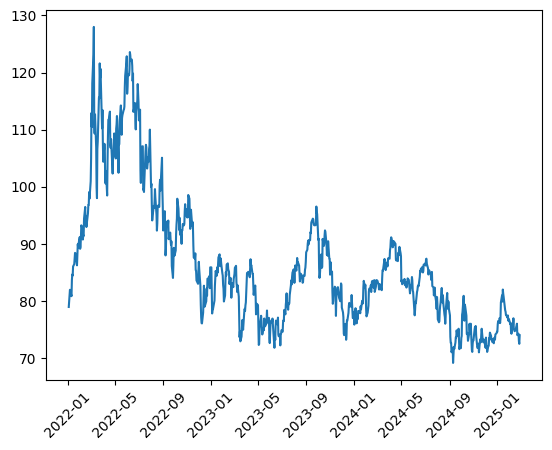

In [13]:
#Visualize
plt.plot(train_data['Price'])
plt.xticks(rotation=45)
plt.show()

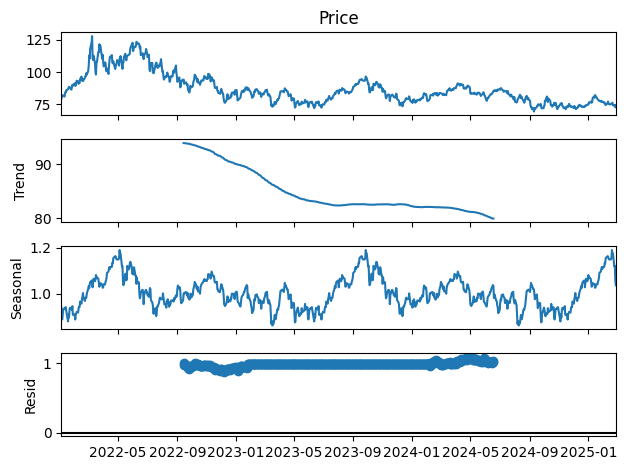

In [14]:
# Decompose Time Series Data

oil_decompose = seasonal_decompose(train_data['Price'],
                                   model = 'multiplicative',
                                   period = 365)

plt.show(oil_decompose.plot())

# **6. Stationary & Volatility Check**

## **6(i) Stationarity**

### ***6(i)(a) Visualize the ACF Plot to check stationarity***

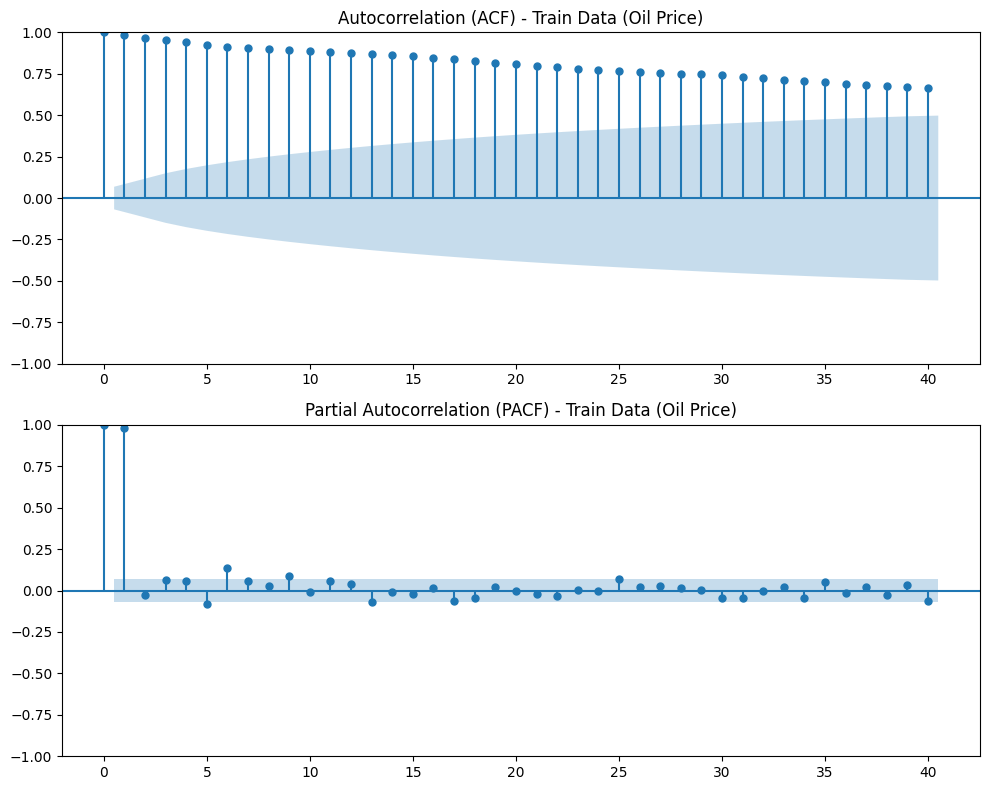

In [15]:
# Define the figure layout
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF: Identify whether time series is stationary or not and the MA (q) term
plot_acf(train_data['Price'], ax=ax1, lags=40, title="Autocorrelation (ACF) - Train Data (Oil Price)")

# Plot PACF: helps identify the AR (p) term
plot_pacf(train_data['Price'], ax=ax2, lags=40, title="Partial Autocorrelation (PACF) - Train Data (Oil Price)")

plt.tight_layout()
plt.show()

# Based on the ACF plot, values decrease very slowly, lingering long past the confidence interval, indicating a strong trend
# Thus, data is non-stationary

### ***6(i)(b) Using ADF Test to check stationarity***

In [16]:
# Check wether dataset is stationary or not
# If p-value is less than 0.05, it means times series is Stationary
# Based on the following hypothesis
# H0:Time Series is not stationary
# H10:Time Series is stationary

adf_result = adfuller(train_data['Price']) # Perform ADF Test

print(f'ADF p-value: {adf_result[1]}')
# ADF p-value: 0.5121417978904079
# Since the p-value is > 0.05, thus fail to reject H0:Time Series is not stationary
# So the oil price is non-stationary

ADF p-value: 0.5121417978904079


### ***6(i)(c) Differencing to make time series data stationary***

In [17]:
# First-order differencing:
diff_price = train_data['Price'].diff().dropna()

### ***6(i)(d) Visualize the ACF Plot to check stationarity***

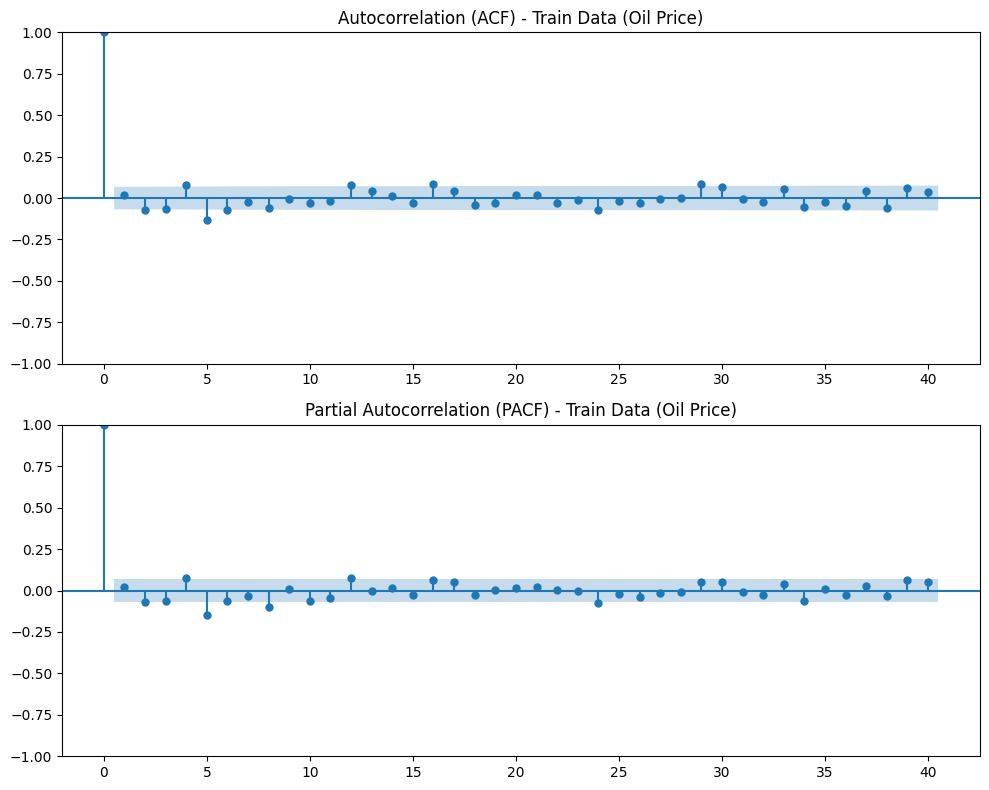

In [18]:
# Define the figure layout
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF: Identify whether time series is stationary or not and the MA (q) term
plot_acf(diff_price, ax=ax1, lags=40, title="Autocorrelation (ACF) - Train Data (Oil Price)")

# Plot PACF: helps identify the AR (p) term
plot_pacf(diff_price, ax=ax2, lags=40, title="Partial Autocorrelation (PACF) - Train Data (Oil Price)")

plt.tight_layout()
plt.show()

# After performed First-Order Differencing, the time series data seems stationary
# ACF bars drop quickly to within the confidence interval) after at Lag 1
# Based on ACF plot, the MA model is MA(1) due to sharp cutoff after lag 1
# Based on PACF plot, the AR model is AR(1) due to sharp cutoff after lag 1

### ***6(i)(e) Using ADF Test to check stationarity***

In [19]:
# Check wether dataset is stationary or not
# If p-value is less than 0.05, it means times series is Stationary
# Based on the following hypothesis
# H0:Time Series is not stationary
# H10:Time Series is stationary

adf_result = adfuller(diff_price) # Perform ADF Test

print(f'ADF p-value: {adf_result[1]}')
# ADF p-value: 1.2775062631908764e-16
# Since the p-value is less than 0.05, thus reject H0:Time Series is not stationary
# So the time series data is stationary

ADF p-value: 1.2775062631908764e-16


## **6(ii) Volatility Clustering - for GARCH**

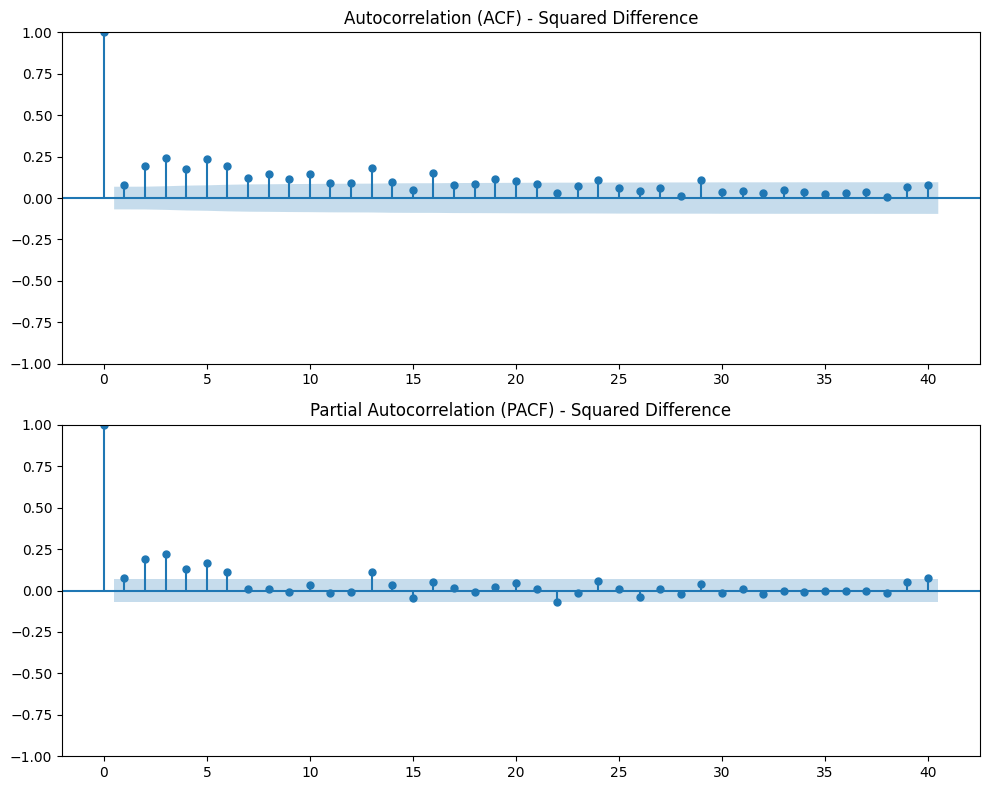

In [20]:
# Volatility clustering means large changes tend to be followed by large changes, and small changes by small changes

# Create Squared Differences based on output of previous differencing

sq_diff = diff_price**2

# Define the figure layout
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF : SQUARED differences
plot_acf(sq_diff, ax=ax1, lags=40, title="Autocorrelation (ACF) - Squared Difference")

# Plot PACF : SQUARED differences
plot_pacf(sq_diff, ax=ax2, lags=40, title="Partial Autocorrelation (PACF) - Squared Difference")

plt.tight_layout()
plt.show()

# Based on the ACF and PACF plot of Squared Difference,
# There is a significant, positive spike at Lag 1.
# The following lags also significant because there are outside the confidence interval.
# Thus, A GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model is required.
# The significant autocorrelation in the Squared Differences indicate volatility clustering exist in the oil price data set.
# It shows that the size of price change today is correleted with the size of the price change yesterday.
# This volatility shows data is heteroskedastic (not constant) which is suitable to be used with the GARCH model.

# **7. Modelling the Data Set**

### ***Option 1 : ARIMA - GARCH***

In [21]:
# Fit ARIMA Modelling
# (p,d,q) = (1,1,1)
arima_model = ARIMA(train_data['Price'], order=(1, 1, 1)).fit()
arima_resid = arima_model.resid

# Fit GARCH Modelling
# For GARCH, p = 1 and q = 1 which frequently sufficient for financial data
# mean='Zero' because this has been cater by ARIMA model above
garch_model = arch_model(arima_resid,
                         vol='Garch', p=1, q=1,
                         mean = "Zero",
                         dist='t').fit(disp='off')

# GARCH Model summary of results
print(garch_model.summary())

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -1653.94
Distribution:      Standardized Student's t   AIC:                           3315.88
Method:                  Maximum Likelihood   BIC:                           3334.74
                                              No. Observations:                  824
Date:                      Mon, Jan 12 2026   Df Residuals:                      824
Time:                              10:28:43   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega  

**Based on the ARIMA-GARCH model above:**

*   **Volatility Model**
    *   The p-value for alpha[1] is  1.229e-03 < 0.05. This is significant which indicates immediate market shocks impact volatility.
    *   The p-value for beta[1] is  8.416e-16  < 0.05. This is significant which indicates Volatility is very long-lasting (persistent).

*   **Distribution**
    *   The p-value for nu is  3.849e-07 < 0.05. This is significant which indicates there are more extreme price jumps than a normal bell curve would predict.




### ***Option 2 : AR - GARCH***

In [22]:
# Fit AR-GARCH Modelling
# Use 'diff_price' variable which already went through differencing.
# So no need to set differencing value
# Specify <mean = "AR"> to indicate the use of AR.
# And Lags value based on the PACF plot
# Why AR is use because financial returns often show "momentum" which captured by AR
# For GARCH, p = 1 and q = 1 which frequently sufficient for financial data

AR_Garch_model = arch_model(diff_price,
                   mean = "AR", lags = 1,
                   vol = "Garch", p = 1, q = 1,
                   dist='t').fit(disp='off')

# ARIMA-GARCH Model summary of results
print(AR_Garch_model.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                        Price   R-squared:                      -0.000
Mean Model:                              AR   Adj. R-squared:                 -0.002
Vol Model:                            GARCH   Log-Likelihood:               -1603.40
Distribution:      Standardized Student's t   AIC:                           3218.80
Method:                  Maximum Likelihood   BIC:                           3247.07
                                              No. Observations:                  822
Date:                      Mon, Jan 12 2026   Df Residuals:                      820
Time:                              10:28:43   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
C

**Based on the AR-GARCH model above:**

*   **Mean Model**
    *   The p-value for Price[1] is 0.456 > 0.05. This is not significant which indicates that the yesterday's price change does not predict today's direction.

*   **Volatility Model**
    *   The p-value for alpha[1] is  1.957e-03 < 0.05. This is significant which indicates immediate market shocks impact volatility.
    *   The p-value for beta[1] is  0.000 < 0.05. This is significant which indicates Volatility is very long-lasting (persistent).

*   **Distribution**
    *   The p-value for nu is  5.759e-06 < 0.05. This is significant which indicates there are more extreme price jumps than a normal bell curve would predict.




**SUMMARY**

**Between AR-GARCH model and ARIMA-Garch model, AR-GARCH model is a better model since its AIC value at  3218.80 is lower than  3315.88 (ZMG Model).**

# **8. Forecast - Using ARIMA-GARCH Model**

In [23]:
# Forecast ARIMA
# This will give the Forecasted Price Level
horizon = len(test_data)
fc_arima = arima_model.forecast(steps = horizon)
fc_price_pl_arima = fc_arima

# Forecast Expected Daily Change
last_price =  train_data['Price'].iloc[-1]
price_series = np.insert(fc_price_pl_arima.values, 0, last_price)
fc_mean_arima = np.diff(price_series)

# Forecast GARCH
fc_garch = garch_model.forecast(horizon = horizon, reindex = False)

# Forecast Variance (Expected Volatility)
fc_var_garch = fc_garch.variance.iloc[-1]

# Calculate Standard Deviation Daily Changes which is the basis
# to calculate the “Daily Changes” confidence interval
fc_sd_dc_garch = np.sqrt(fc_var_garch.values)

# Calculate Standard Deviation Price Level which is the basis
# to calculate the “Price Level” confidence interval
# .cumsum() is use for price level because the uncertainty will accumulate for day to day
fc_sd_pl_garch = np.sqrt(fc_var_garch.cumsum().values)

# Create robust “day” variable
days = np.arange(1, horizon + 1)

# Calculate t-multiplier for confidence interval
# When using dist = ‘t’ in garch model, the fixed multiplier of 1.96 is not suitable because it will likely underestimate the risk
# since 1.96 assume the data is normally distributed

# Extract Degree of Freedom (nu)
dof = garch_model.params['nu']

# Calculate multiplier for 95% confidence
# use 0.975 for 2-tailed 95% interval
t_mult = t.ppf(0.975, df = dof)

# Create dataframe to store information on AR-GARCH
arima_garch_df = pd.DataFrame ({
    'day' : days,
    'actual_price': test_data['Price'].values,
    'daily_change' : fc_mean_arima,
    'daily_sd' : fc_sd_dc_garch,
    'forecast_price' : fc_price_pl_arima.values,
    'price_sd' : fc_sd_pl_garch
    }, index=test_data.index)

# Add Confidence Interval For Daily Changes
arima_garch_df['lwr_dc'] = arima_garch_df['daily_change'] - (t_mult* arima_garch_df['daily_sd'])
arima_garch_df['upr_dc'] = arima_garch_df['daily_change'] + (t_mult* arima_garch_df['daily_sd'])

# Add Confidence Interval For Price Level
arima_garch_df['lwr_pl'] = arima_garch_df['forecast_price'] - (t_mult* arima_garch_df['price_sd'])
arima_garch_df['upr_pl'] = arima_garch_df['forecast_price'] + (t_mult* arima_garch_df['price_sd'])


In [24]:
print("head".title())
arima_garch_df.head(5)

Head


,day,actual_price,daily_change,daily_sd,forecast_price,price_sd,lwr_dc,upr_dc,lwr_pl,upr_pl
Date,,,,,,,,,,
2025-02-28,1,73.18,0.052986,1.391490,74.092986,1.391490,-3.335826,3.441797,70.704174,77.481797
2025-03-03,2,71.62,0.044505,1.441228,74.137490,2.003343,-3.465440,3.554450,69.258581,79.016400
2025-03-04,3,71.04,0.037381,1.486105,74.174872,2.494372,-3.581856,3.656619,68.100118,80.249626
2025-03-05,4,69.30,0.031398,1.526760,74.206270,2.924532,-3.686850,3.749646,67.083910,81.328629
2025-03-06,5,69.46,0.026372,1.563715,74.232642,3.316337,-3.781874,3.834618,66.156087,82.309197


In [25]:
print("tail".title())
arima_garch_df.tail(5)

Tail


,day,actual_price,daily_change,daily_sd,forecast_price,price_sd,lwr_dc,upr_dc,lwr_pl,upr_pl
Date,,,,,,,,,,
2025-12-08,202,62.49,0.0,2.005035,74.371034,27.950881,-4.883032,4.883032,6.299899,142.442170
2025-12-09,203,61.94,0.0,2.005035,74.371034,28.022703,-4.883032,4.883032,6.124983,142.617085
2025-12-10,204,62.21,0.0,2.005035,74.371034,28.094342,-4.883032,4.883032,5.950515,142.791554
2025-12-11,205,61.28,0.0,2.005035,74.371034,28.165799,-4.883032,4.883032,5.776490,142.965578
2025-12-12,206,61.12,0.0,2.005035,74.371034,28.237075,-4.883032,4.883032,5.602906,143.139163


### ***MAE & RMSE***

In [26]:
# 1. Ensure both are the same length (30 days)
# actual_prices should be the 30 days of real data the model hasn't seen
actuals = arima_garch_df['actual_price'].values
predictions = arima_garch_df['forecast_price'].values

# 2. Calculate MAE
mae = mean_absolute_error(actuals, predictions)

# 3. Calculate RMSE
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

# 4. Print results
print(f"--- Model Performance Metrics ---")
print(f"MAE  (Mean Absolute Error):  {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")

--- Model Performance Metrics ---
MAE  (Mean Absolute Error):  7.6861
RMSE (Root Mean Squared Error): 8.3625


### ***Residuals Plot***

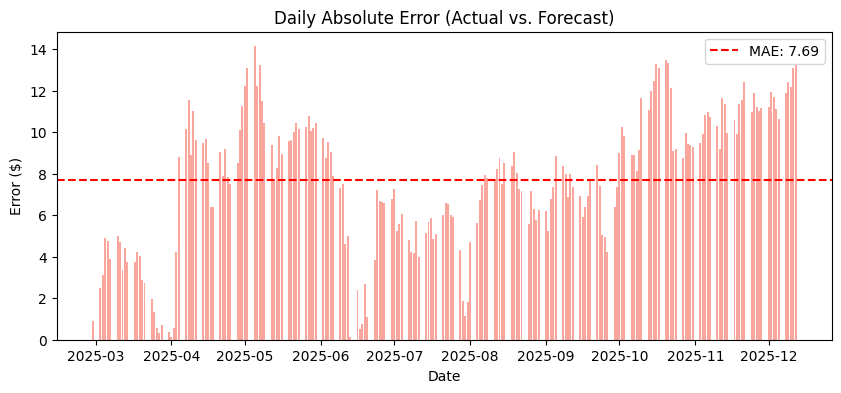

In [27]:
# Plotting the residuals
plt.figure(figsize=(10, 4))
plt.bar(arima_garch_df.index,
        np.abs(arima_garch_df['actual_price'] - arima_garch_df['forecast_price']),
               color='salmon', alpha=0.7)
plt.axhline(y=7.6861, color='red', linestyle='--', label=f'MAE: 7.69')
plt.title('Daily Absolute Error (Actual vs. Forecast)')
plt.xlabel('Date')
plt.ylabel('Error ($)')
plt.legend()
plt.show()

### ***Daily Changes Plot***

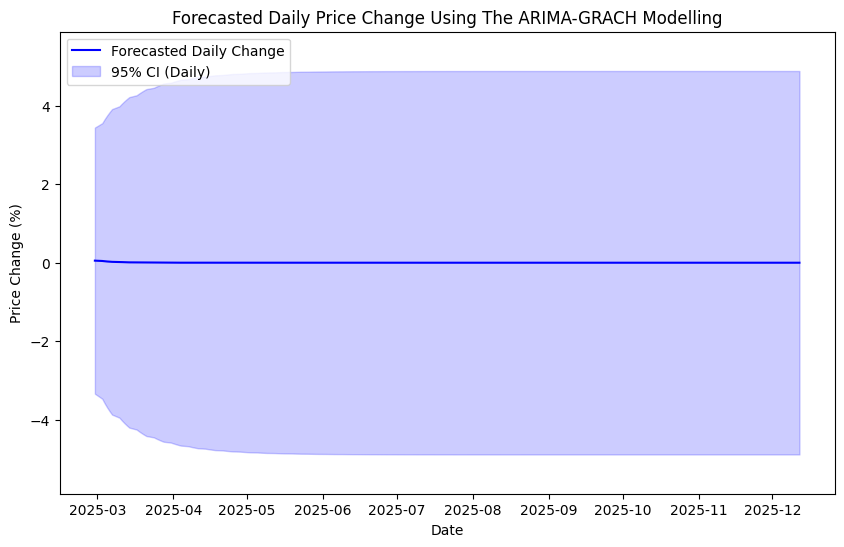

In [28]:
# Define plot size
plt.figure(figsize=(10, 6))

# Plot Forecasted Daily Change
plt.plot(arima_garch_df.index, arima_garch_df['daily_change'],
         label='Forecasted Daily Change', color='blue')

# Plot Confidence Interval
plt.fill_between(arima_garch_df.index,
                 arima_garch_df['lwr_dc'],
                 arima_garch_df['upr_dc'],
                 alpha=0.2, color='blue', label='95% CI (Daily)')

# Formatting
plt.title('Forecasted Daily Price Change Using The ARIMA-GRACH Modelling')
plt.xlabel('Date')
plt.ylabel('Price Change (%)')
plt.ylim(arima_garch_df['lwr_dc'].min() - 1, arima_garch_df['upr_dc'].max() + 1)
plt.legend()

plt.show()


### ***Price Level Plot***

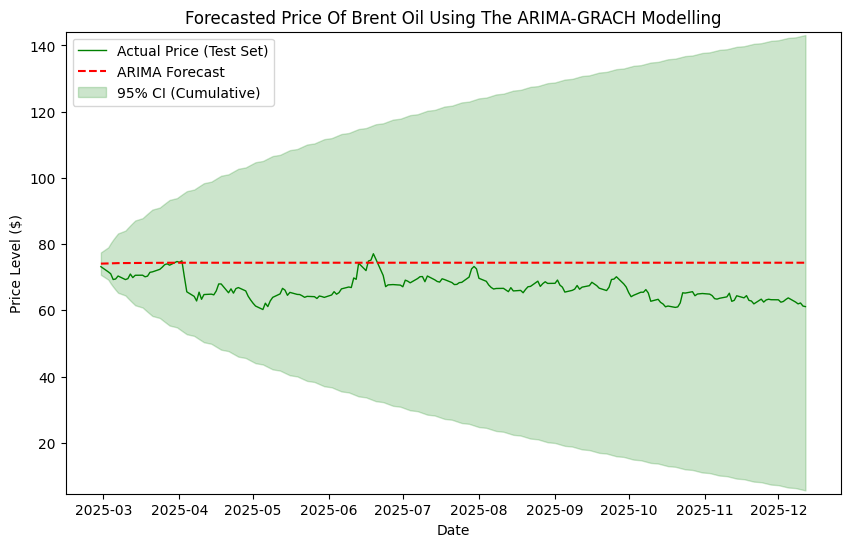

In [29]:
# Define plot size
plt.figure(figsize=(10, 6))

# Plot the Actuals vs Forecast
plt.plot(arima_garch_df.index, arima_garch_df['actual_price'], label='Actual Price (Test Set)', color='green', linewidth=1)
plt.plot(arima_garch_df.index, arima_garch_df['forecast_price'], label='ARIMA Forecast', color='red', linestyle='--')

# Plot Confidence Interval
plt.fill_between(arima_garch_df.index,
                 arima_garch_df['lwr_pl'],
                 arima_garch_df['upr_pl'],
                 alpha=0.2, color='green', label='95% CI (Cumulative)')

# Formatting
plt.title('Forecasted Price Of Brent Oil Using The ARIMA-GRACH Modelling')
plt.xlabel('Date')
plt.ylabel('Price Level ($)')
plt.ylim(arima_garch_df['lwr_pl'].min() - 1, arima_garch_df['upr_pl'].max() + 1)
plt.legend()

plt.show()


# **9. Forecast - Using AR-GARCH Model**

In [30]:
# Forecast
horizon = len(test_data)
fc_ar_garch = AR_Garch_model.forecast(horizon = horizon, reindex = False)

# Forecast Mean (Expected Daily Changes)
fc_mean_ar_garch = fc_ar_garch.mean.iloc[-1]

# Forecast Variance (Expected Volatility)
fc_var_ar_garch = fc_ar_garch.variance.iloc[-1]

# Calculate Standard Deviation Daily Changes which is the basis
# to calculate the “Daily Changes” confidence interval
fc_sd_dc_ar_garch = np.sqrt(fc_var_ar_garch.values)

# Calculate Standard Deviation Price Level which is the basis
# to calculate the “Price Level” confidence interval
# .cumsum() is use for price level because the uncertainty will accumulate for day to day
fc_sd_pl_ar_garch = np.sqrt(fc_var_ar_garch.cumsum().values)

# Calculate Forecasted Price Level
last_price =  train_data['Price'].iloc[-1]
fc_price_pl_ar_garch = last_price + fc_mean_ar_garch.cumsum()

# Create robust “day” variable
days = np.arange(1, horizon + 1)

# Calculate t-multiplier for confidence interval
# When using dist = ‘t’ in garch model, the fixed multiplier of 1.96 is not suitable because it will likely underestimate the risk
# since 1.96 assume the data is normally distributed

# Extract Degree of Freedom (nu)
dof = AR_Garch_model.params['nu']

# Calculate multiplier for 95% confidence
# use 0.975 for 2-tailed 95% interval
t_mult = t.ppf(0.975, df = dof)

# Create dataframe to store information on AR-GARCH
ar_garch_df = pd.DataFrame ({
    'day' : days,
    'actual_price': test_data['Price'].values,
    'daily_change' : fc_mean_ar_garch.values,
    'daily_sd' : fc_sd_dc_ar_garch,
    'forecast_price' : fc_price_pl_ar_garch.values,
    'price_sd' : fc_sd_pl_ar_garch
    }, index=test_data.index)

# Add Confidence Interval For Daily Changes
ar_garch_df['lwr_dc'] = ar_garch_df['daily_change'] - (t_mult* ar_garch_df['daily_sd'])
ar_garch_df['upr_dc'] = ar_garch_df['daily_change'] + (t_mult* ar_garch_df['daily_sd'])

# Add Confidence Interval For Price Level
ar_garch_df['lwr_pl'] = ar_garch_df['forecast_price'] - (t_mult* ar_garch_df['price_sd'])
ar_garch_df['upr_pl'] = ar_garch_df['forecast_price'] + (t_mult* ar_garch_df['price_sd'])


In [31]:
# Validation Check: Compare Forecasted Mean to Historical Average
hist_avg_change = diff_price.mean()
fc_avg_change = fc_mean_ar_garch.mean()

print(f"--- VALIDATION CHECKS ---")
print(f"Historical Avg Daily Change: {hist_avg_change:.4f}")
print(f"Forecasted Avg Daily Change: {fc_avg_change:.4f}")

if abs(fc_avg_change) > abs(hist_avg_change) * 10:
    print("WARNING: Your forecast mean is much larger than historical. Check if you scaled by 100.")
else:
    print("SUCCESS: Forecast mean scale looks consistent with history.")

--- VALIDATION CHECKS ---
Historical Avg Daily Change: -0.0060
Forecasted Avg Daily Change: 0.0535
SUCCESS: Forecast mean scale looks consistent with history.


In [32]:
print("head".title())
ar_garch_df.head(5)

Head


,day,actual_price,daily_change,daily_sd,forecast_price,price_sd,lwr_dc,upr_dc,lwr_pl,upr_pl
Date,,,,,,,,,,
2025-02-28,1,73.18,0.088263,1.140370,74.128263,1.140370,-2.588394,2.764920,71.451606,76.804920
2025-03-03,2,71.62,0.054191,1.149625,74.182454,1.619284,-2.644190,2.752571,70.381697,77.983210
2025-03-04,3,71.04,0.053374,1.158422,74.235828,1.990985,-2.665656,2.772404,69.562620,78.909036
2025-03-05,4,69.30,0.053355,1.167088,74.289183,2.307838,-2.686015,2.792725,68.872263,79.706103
2025-03-06,5,69.46,0.053354,1.175625,74.342537,2.590021,-2.706055,2.812763,68.263280,80.421794


In [33]:
print("tail".title())
ar_garch_df.tail(5)

Tail


,day,actual_price,daily_change,daily_sd,forecast_price,price_sd,lwr_dc,upr_dc,lwr_pl,upr_pl
Date,,,,,,,,,,
2025-12-08,202,62.49,0.053354,1.850691,84.853324,23.007846,-4.290558,4.397267,30.849678,138.856971
2025-12-09,203,61.94,0.053354,1.851903,84.906679,23.082256,-4.293403,4.400111,30.728379,139.084978
2025-12-10,204,62.21,0.053354,1.853105,84.960033,23.156522,-4.296224,4.402932,30.607416,139.312650
2025-12-11,205,61.28,0.053354,1.854297,85.013387,23.230647,-4.299022,4.405730,30.486787,139.539987
2025-12-12,206,61.12,0.053354,1.855479,85.066741,23.304629,-4.301797,4.408505,30.366490,139.766993


### ***MAE & RMSE***

In [34]:
# 1. Ensure both are the same length (30 days)
# actual_prices should be the 30 days of real data the model hasn't seen
actuals = ar_garch_df['actual_price'].values
predictions = ar_garch_df['forecast_price'].values

# 2. Calculate MAE
mae = mean_absolute_error(actuals, predictions)

# 3. Calculate RMSE
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

# 4. Print results
print(f"--- Model Performance Metrics ---")
print(f"MAE  (Mean Absolute Error):  {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")

--- Model Performance Metrics ---
MAE  (Mean Absolute Error):  12.8612
RMSE (Root Mean Squared Error): 14.0558


### ***Residuals Plot***

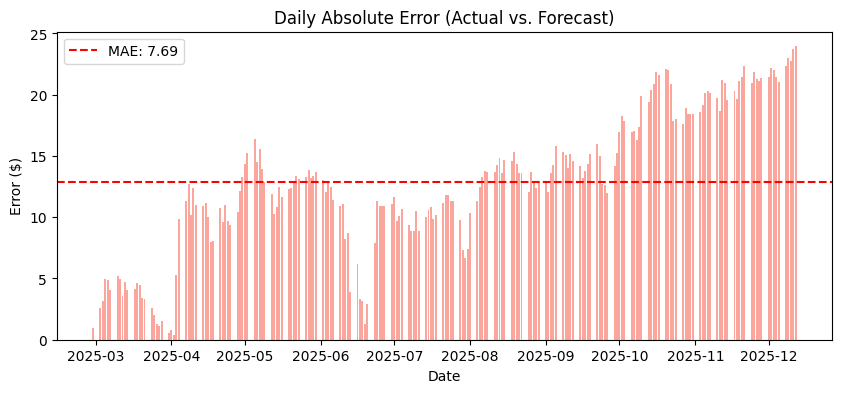

In [35]:
# Plotting the residuals
plt.figure(figsize=(10, 4))
plt.bar(ar_garch_df.index,
        np.abs(ar_garch_df['actual_price'] - ar_garch_df['forecast_price']),
               color='salmon', alpha=0.7)
plt.axhline(y=12.8612, color='red', linestyle='--', label=f'MAE: 7.69')
plt.title('Daily Absolute Error (Actual vs. Forecast)')
plt.xlabel('Date')
plt.ylabel('Error ($)')
plt.legend()
plt.show()

### ***Daily Changes Plot***

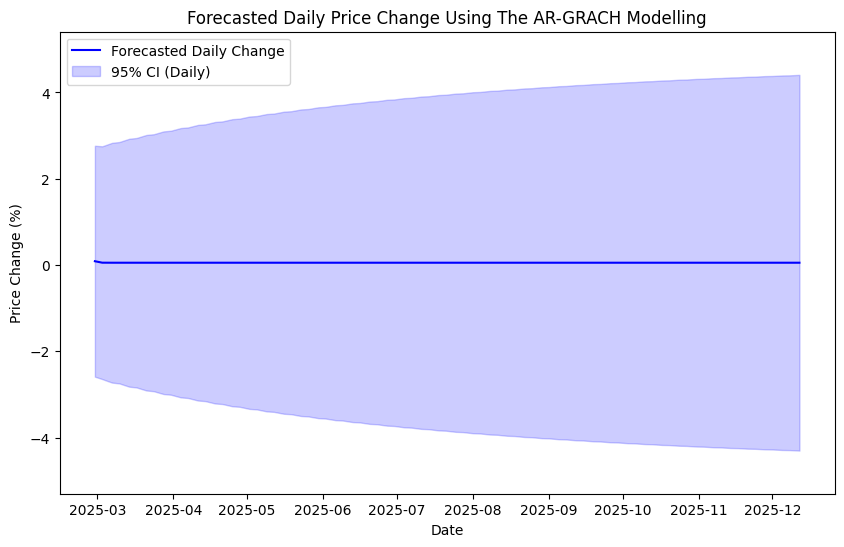

In [36]:
# Define plot size
plt.figure(figsize=(10, 6))

# Plot Forecasted Daily Change
plt.plot(ar_garch_df.index, ar_garch_df['daily_change'],
         label='Forecasted Daily Change', color='blue')

# Plot Confidence Interval
plt.fill_between(ar_garch_df.index,
                 ar_garch_df['lwr_dc'],
                 ar_garch_df['upr_dc'],
                 alpha=0.2, color='blue', label='95% CI (Daily)')

# Formatting
plt.title('Forecasted Daily Price Change Using The AR-GRACH Modelling')
plt.xlabel('Date')
plt.ylabel('Price Change (%)')
plt.ylim(ar_garch_df['lwr_dc'].min() - 1, ar_garch_df['upr_dc'].max() + 1)
plt.legend()

plt.show()

### ***Price Level Plot***

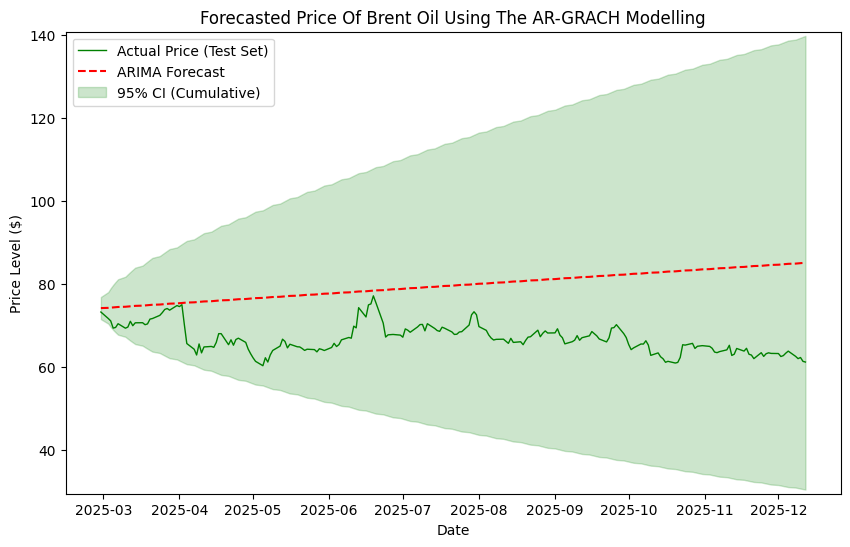

In [37]:
# Define plot size
plt.figure(figsize=(10, 6))

# Plot the Actuals vs Forecast
plt.plot(ar_garch_df.index, ar_garch_df['actual_price'], label='Actual Price (Test Set)', color='green', linewidth=1)
plt.plot(ar_garch_df.index, ar_garch_df['forecast_price'], label='ARIMA Forecast', color='red', linestyle='--')

# Plot Confidence Interval
plt.fill_between(ar_garch_df.index,
                 ar_garch_df['lwr_pl'],
                 ar_garch_df['upr_pl'],
                 alpha=0.2, color='green', label='95% CI (Cumulative)')

# Formatting
plt.title('Forecasted Price Of Brent Oil Using The AR-GRACH Modelling')
plt.xlabel('Date')
plt.ylabel('Price Level ($)')
plt.ylim(ar_garch_df['lwr_pl'].min() - 1, ar_garch_df['upr_pl'].max() + 1)
plt.legend()

plt.show()

# **Conclusion**

1. **Trend Capture:** The ARIMA-GARCH model's MAE of 7.6861 suggests its integrated nature ($d=1$) and Moving Average component allowed it to track the underlying "drift" of the oil market much better than a simple AR(1) model.

2. **Error Magnitude:** The AR-GARCH model's MAE of 12.8612 indicates it likely "drifted" away from the actual price path earlier in the 9-month window. This often happens because AR(1) models revert to a long-run mean too quickly, failing to capture the stochastic trends inherent in energy commodities.

3. **Risk Management:** The RMSE values ($8.36$ vs $14.05$) confirm that ARIMA-GARCH is more reliable for risk assessment. In oil trading, the higher RMSE of the AR-GARCH model would imply a higher risk of "large misses" during volatile months.
